In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import LocalOutlierFactor



In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [ ]:
df=pd.read_csv("/content/sample_data/bank-additional-full.csv",sep=';')

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
num_cols=(df.select_dtypes(["int64","float64"]))

In [ ]:
df["pdays"] = df["pdays"].apply(lambda x: 0 if x == 999 else 1)

In [ ]:
df.previous = df.previous.apply(lambda x: 1 if x > 0 else 0)

In [ ]:
num_cols.drop(["pdays","previous"],axis=1,inplace=True)

In [ ]:


from sklearn.metrics import silhouette_score

X = num_cols.values


neighbor_range = np.arange(2, 10)
best_score = -1
best_n_neighbors = None

for n_neighbors in neighbor_range:
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    y_pred = lof.fit_predict(X)


    score = silhouette_score(X, y_pred)

    if score > best_score:
        best_score = score
        best_n_neighbors = n_neighbors

print(f"En iyi n_neighbors: {best_n_neighbors} (Silhouette Skoru: {best_score})")


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


En iyi n_neighbors: 2 (Silhouette Skoru: 0.09384395279159394)


In [ ]:
lof = LocalOutlierFactor(n_neighbors=2)
y_pred = lof.fit_predict(num_cols)

df['Outlier'] = y_pred


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [ ]:


df_cleaned = df[df['Outlier'] != -1].drop(columns=['Outlier'])

print(df_cleaned)


       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41182   29   unemployed   single             basic.4y       no     yes   no   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   

         contact month day_of_week  ...  campaign  

In [ ]:
df_cleaned["euribor3m*emp.var.rate*nr.employed"]=df_cleaned['euribor3m']*df_cleaned['emp.var.rate']*df_cleaned['nr.employed']

In [ ]:
df_cleaned.drop(["euribor3m","nr.employed","emp.var.rate"],inplace=True,axis=1)

In [ ]:
df_cleaned.drop(df_cleaned[(df_cleaned["duration"]==0)].index,inplace=True)

In [ ]:
df_cleaned[["job","marital","loan","default","housing","education"]]=df_cleaned[["job","marital","loan","default","housing","education"]].replace("unknown",np.NaN)

In [ ]:

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder


categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()
for col in categorical_cols:
    df_cleaned[col] = label_encoder.fit_transform(df_cleaned[col].astype(str))


imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=0)
df_clean_imputed = imputer.fit_transform(df_cleaned)

df_clean_imputed = pd.DataFrame(df_clean_imputed, columns=df_cleaned.columns)
print(df_clean_imputed.head())



    age  job  marital  education  default  housing  loan  contact  month  \
0  56.0  3.0      1.0        0.0      1.0      1.0   1.0      1.0    6.0   
1  57.0  8.0      1.0        3.0      0.0      1.0   1.0      1.0    6.0   
2  37.0  8.0      1.0        3.0      1.0      2.0   1.0      1.0    6.0   
3  40.0  0.0      1.0        1.0      1.0      1.0   1.0      1.0    6.0   
4  56.0  8.0      1.0        3.0      1.0      1.0   2.0      1.0    6.0   

   day_of_week  duration  campaign  pdays  previous  poutcome  cons.price.idx  \
0          1.0     261.0       1.0    0.0       0.0       1.0          93.994   
1          1.0     149.0       1.0    0.0       0.0       1.0          93.994   
2          1.0     226.0       1.0    0.0       0.0       1.0          93.994   
3          1.0     151.0       1.0    0.0       0.0       1.0          93.994   
4          1.0     307.0       1.0    0.0       0.0       1.0          93.994   

   cons.conf.idx    y  euribor3m*emp.var.rate*nr.employe

In [ ]:
df_cleaned=df_clean_imputed

In [ ]:
X=df_cleaned.drop("y",axis=1)
y=df_cleaned["y"]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

In [ ]:
scaler=MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from collections import Counter

class_counts = Counter(y_train)
total_samples = len(y_train)

weights = {cls: total_samples / count for cls, count in class_counts.items()}
print("Sınıf Ağırlıkları:", weights)

Sınıf Ağırlıkları: {0.0: 1.1211663226186965, 1.0: 9.253118344995437}


# **Models**

**Svm-weight Class**

Accuracy: 0.8485

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.91      6766
         1.0       0.41      0.89      0.56       838

    accuracy                           0.85      7604
   macro avg       0.70      0.87      0.74      7604
weighted avg       0.92      0.85      0.87      7604


Confusion Matrix:
[[5707 1059]
 [  93  745]]


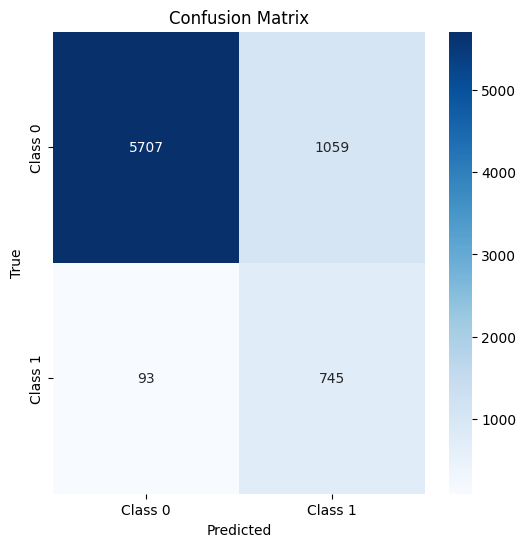

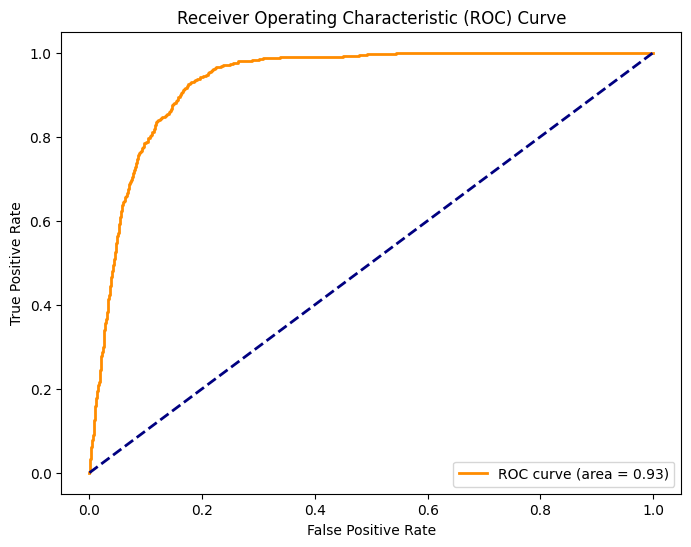


Tuned Model Accuracy: 0.8524

Tuned Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      6766
         1.0       0.42      0.84      0.56       838

    accuracy                           0.85      7604
   macro avg       0.70      0.85      0.73      7604
weighted avg       0.92      0.85      0.87      7604


Tuned Confusion Matrix:
[[5779  987]
 [ 135  703]]


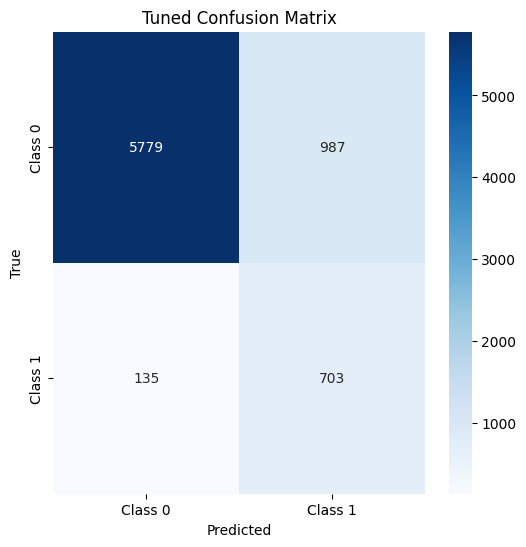

In [ ]:

clf = SVC(class_weight={0: weights[0], 1: weights[1]}, random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, clf.decision_function(X_test_scaled))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

clf_tuned = SVC(class_weight={0: weights[0], 1: weights[1]}, C=10, kernel='rbf', random_state=42)
clf_tuned.fit(X_train_scaled, y_train)

y_pred_tuned = clf_tuned.predict(X_test_scaled)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned Model Accuracy: {accuracy_tuned:.4f}")

print("\nTuned Classification Report:")
print(classification_report(y_test, y_pred_tuned))

conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
print("\nTuned Confusion Matrix:")
print(conf_matrix_tuned)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Tuned Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**Svm-smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE: [27128 27128]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.86      0.91      6766
         1.0       0.43      0.87      0.57       838

    accuracy                           0.86      7604
   macro avg       0.70      0.86      0.74      7604
weighted avg       0.92      0.86      0.88      7604

Confusion Matrix:
 [[5790  976]
 [ 113  725]]
ROC AUC Score: 0.9309621955065231


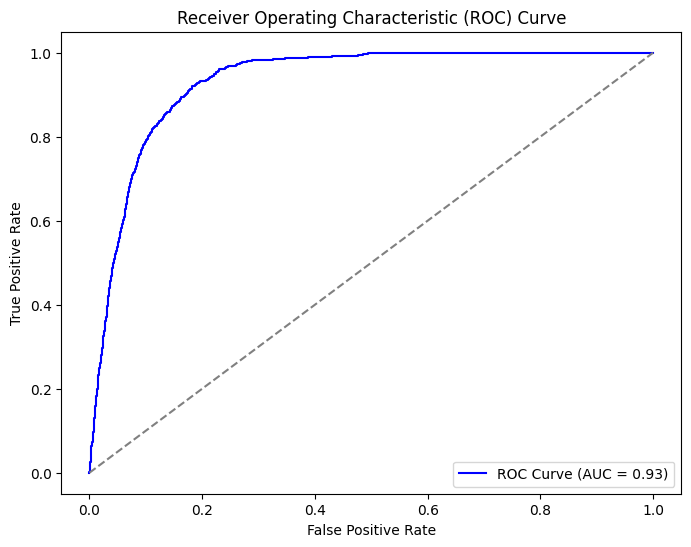

In [ ]:

from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE



smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Class distribution after SMOTE: {np.bincount(y_resampled)}")

svm_clf = SVC(kernel='rbf',class_weight="balanced", C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_resampled, y_resampled)

y_pred = svm_clf.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

y_prob = svm_clf.decision_function(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Svm-Baggingclassifier**

In [ ]:

from sklearn.ensemble import BaggingClassifier


svm_clf = SVC(kernel='rbf', class_weight='balanced', random_state=42)

ensemble_svm = BaggingClassifier(estimator=svm_clf, n_estimators=10, random_state=42)

ensemble_svm.fit(X_train_scaled, y_train)

y_pred = ensemble_svm.predict(X_test_scaled)


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Confusion Matrix:
[[5760 1006]
 [ 105  733]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      6766
         1.0       0.42      0.87      0.57       838

    accuracy                           0.85      7604
   macro avg       0.70      0.86      0.74      7604
weighted avg       0.92      0.85      0.87      7604



**Svm-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [27128  3287]
RUS sonrası sınıf dağılımı: [3287 3287]

Confusion Matrix:
[[5726 1040]
 [  97  741]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      6766
         1.0       0.42      0.88      0.57       838

    accuracy                           0.85      7604
   macro avg       0.70      0.87      0.74      7604
weighted avg       0.92      0.85      0.87      7604


ROC AUC Score: 0.93


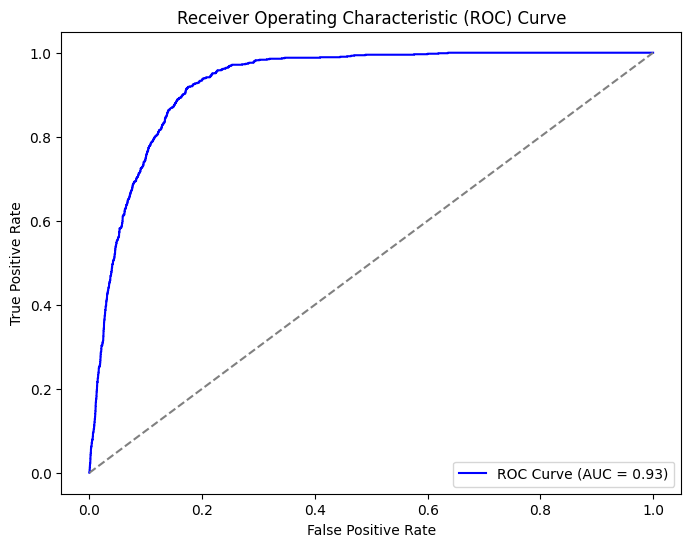

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

svc_clf = SVC(kernel='rbf', probability=True, random_state=42)
svc_clf.fit(X_resampled, y_resampled)

y_pred = svc_clf.predict(X_test_scaled)
y_prob = svc_clf.predict_proba(X_test_scaled)[:, 1]


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Svm-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [27128  3287]
SMOTE+ENN sonrası sınıf dağılımı: [22436 25684]

Confusion Matrix:
[[5627 1139]
 [  90  748]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      6766
         1.0       0.40      0.89      0.55       838

    accuracy                           0.84      7604
   macro avg       0.69      0.86      0.73      7604
weighted avg       0.92      0.84      0.86      7604


ROC AUC Score: 0.93


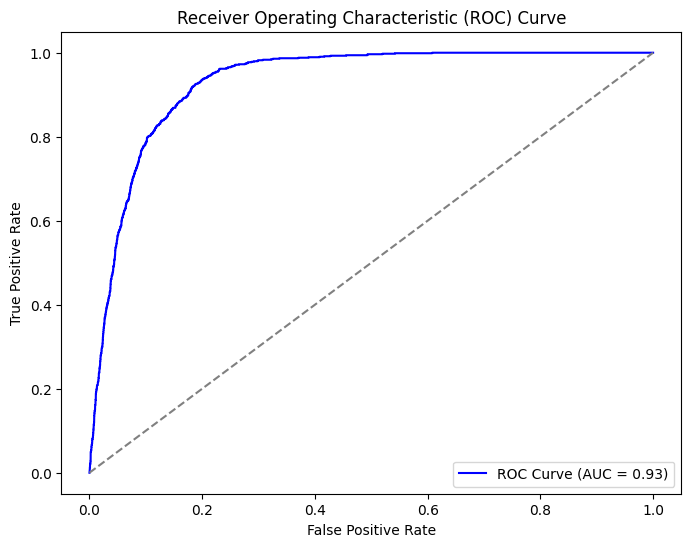

In [ ]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE+ENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

svc_clf = SVC(kernel='rbf', probability=True, random_state=42)
svc_clf.fit(X_resampled, y_resampled)

y_pred = svc_clf.predict(X_test_scaled)
y_prob = svc_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


 **Logistic Regression-Weight Class**

Accuracy: 0.8568

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.91      6766
         1.0       0.43      0.87      0.57       838

    accuracy                           0.86      7604
   macro avg       0.70      0.86      0.74      7604
weighted avg       0.92      0.86      0.88      7604


Confusion Matrix:
[[5788  978]
 [ 111  727]]


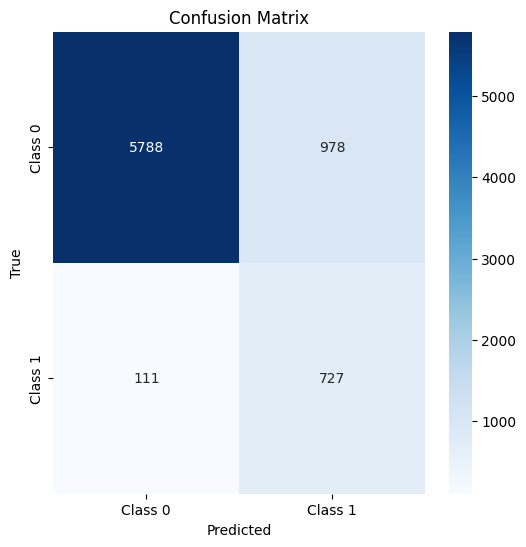

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


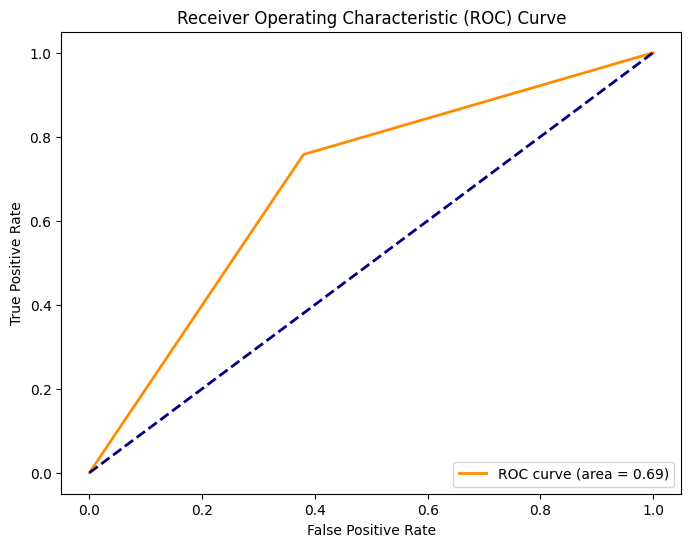


Tuned Model Accuracy: 0.8570

Tuned Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.91      6766
         1.0       0.43      0.87      0.57       838

    accuracy                           0.86      7604
   macro avg       0.70      0.86      0.74      7604
weighted avg       0.92      0.86      0.88      7604


Tuned Confusion Matrix:
[[5790  976]
 [ 111  727]]


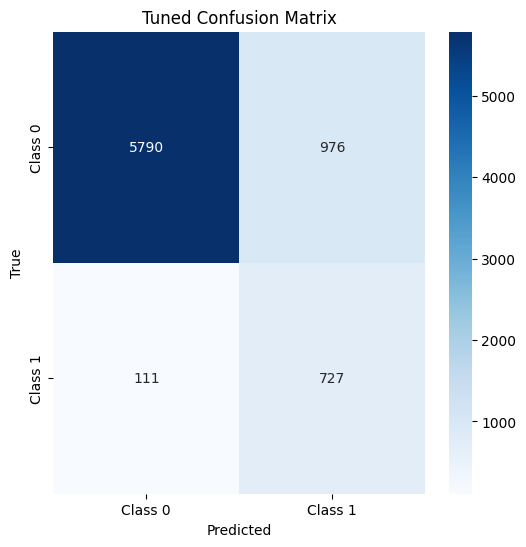

In [ ]:

log_reg = LogisticRegression(class_weight={0: weights[0], 1: weights[1]}, random_state=42, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

log_reg_tuned = LogisticRegression(class_weight={0:weights[0], 1: weights[1] }, random_state=42, C=10, solver='liblinear')
log_reg_tuned.fit(X_train_scaled, y_train)

y_pred_tuned = log_reg_tuned.predict(X_test_scaled)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned Model Accuracy: {accuracy_tuned:.4f}")

print("\nTuned Classification Report:")
print(classification_report(y_test, y_pred_tuned))

conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
print("\nTuned Confusion Matrix:")
print(conf_matrix_tuned)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Tuned Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**Logistic Regression-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [27128  3287]
SMOTE sonrası sınıf dağılımı: [27128 27128]

Confusion Matrix:
[[5823  943]
 [ 120  718]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.92      6766
         1.0       0.43      0.86      0.57       838

    accuracy                           0.86      7604
   macro avg       0.71      0.86      0.75      7604
weighted avg       0.92      0.86      0.88      7604


ROC AUC Score: 0.93


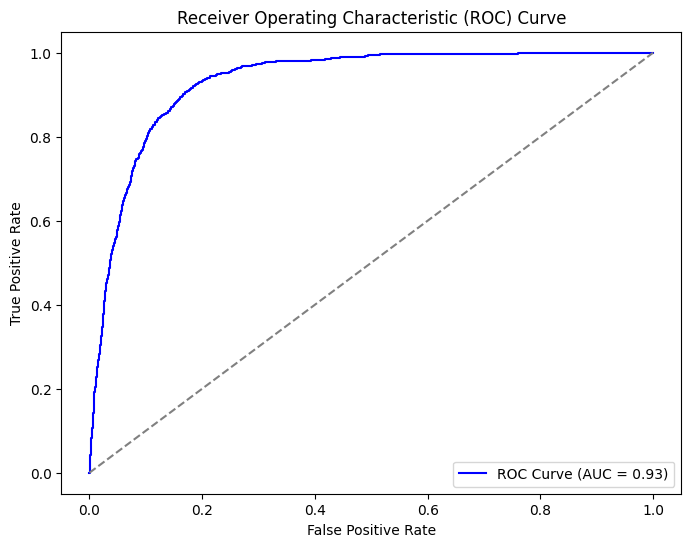

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE



smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

log_reg = LogisticRegression(class_weight="balanced",solver='liblinear', random_state=42)
log_reg.fit(X_resampled, y_resampled)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logistic Regression-Bagging Classifier**


Confusion Matrix:
[[5728 1038]
 [ 126  712]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      6766
         1.0       0.41      0.85      0.55       838

    accuracy                           0.85      7604
   macro avg       0.69      0.85      0.73      7604
weighted avg       0.92      0.85      0.87      7604


ROC AUC Score: 0.92


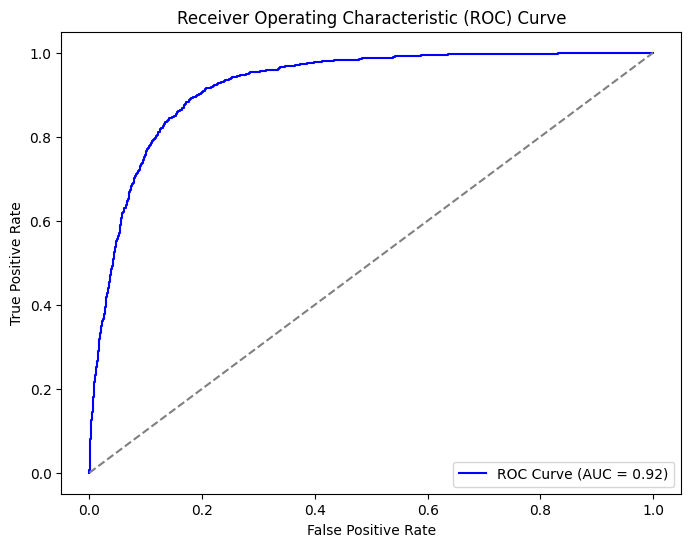

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve




base_model = LogisticRegression(class_weight={0:weights[0], 1: weights[1] },solver='liblinear', random_state=42)
ensemble_model = BaggingClassifier(
    estimator=base_model,
    n_estimators=10,
    random_state=42,
    max_samples=0.8,
    max_features=0.8
)

ensemble_model.fit(X_train_scaled, y_train)

y_pred = ensemble_model.predict(X_test_scaled)
y_prob = ensemble_model.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logistic Regression-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [27128  3287]
RUS sonrası sınıf dağılımı: [3287 3287]

Confusion Matrix:
[[5772  994]
 [ 119  719]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      6766
         1.0       0.42      0.86      0.56       838

    accuracy                           0.85      7604
   macro avg       0.70      0.86      0.74      7604
weighted avg       0.92      0.85      0.87      7604


ROC AUC Score: 0.93


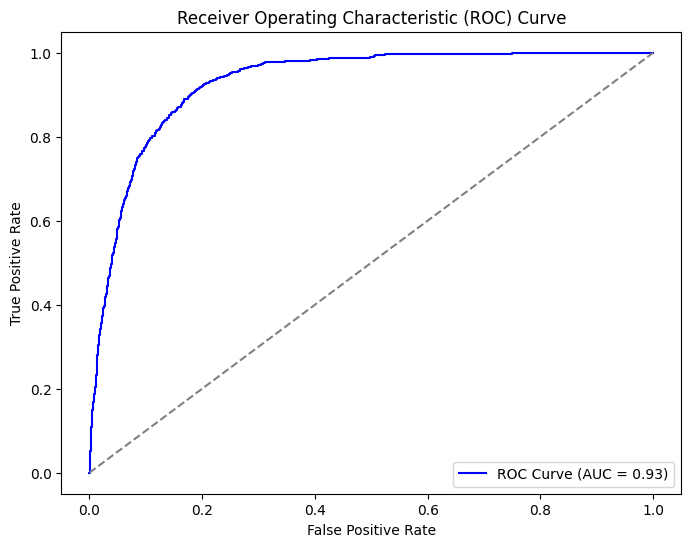

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_resampled, y_resampled)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logistic Regression-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [27128  3287]
SMOTEENN sonrası sınıf dağılımı: [22436 25684]

Confusion Matrix:
[[5621 1145]
 [  88  750]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      6766
         1.0       0.40      0.89      0.55       838

    accuracy                           0.84      7604
   macro avg       0.69      0.86      0.73      7604
weighted avg       0.92      0.84      0.86      7604


ROC AUC Score: 0.93


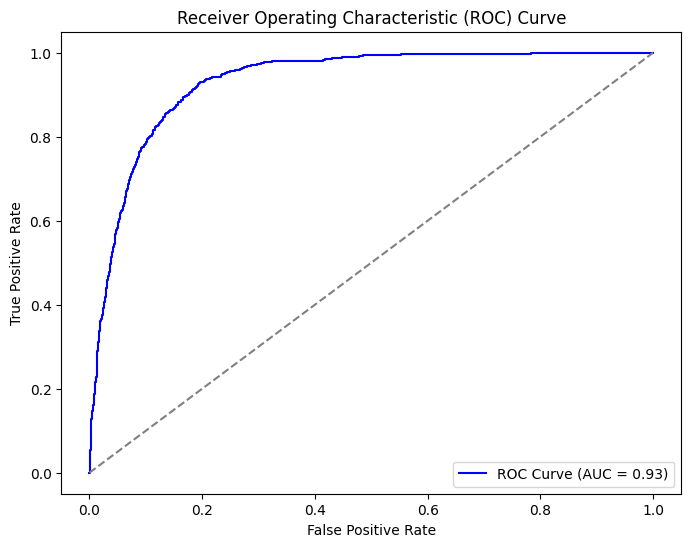

In [ ]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_resampled, y_resampled)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


 **GradientBoost-Weight Class**

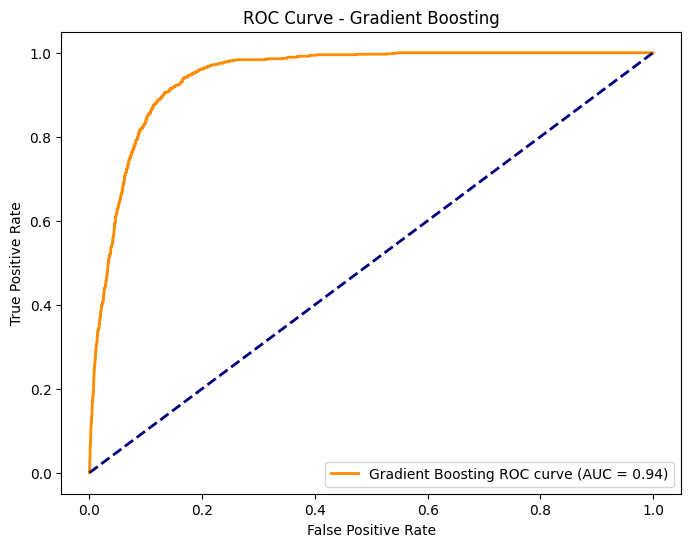


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      6766
         1.0       0.42      0.92      0.58       838

    accuracy                           0.85      7604
   macro avg       0.71      0.88      0.74      7604
weighted avg       0.93      0.85      0.87      7604



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, classification_report


gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

sample_weights = [weights[1] if label == 1 else weights[0]  for label in y_train]

gb.fit(X_train_scaled, y_train, sample_weight=sample_weights)

y_prob_gb = gb.predict_proba(X_test_scaled)[:, 1]

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label='Gradient Boosting ROC curve (AUC = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, gb.predict(X_test_scaled)))


**GradientBoost-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [27128  3287]
SMOTE sonrası sınıf dağılımı: [27128 27128]

Confusion Matrix:
[[6100  666]
 [ 166  672]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.94      6766
         1.0       0.50      0.80      0.62       838

    accuracy                           0.89      7604
   macro avg       0.74      0.85      0.78      7604
weighted avg       0.92      0.89      0.90      7604


ROC AUC Score: 0.94


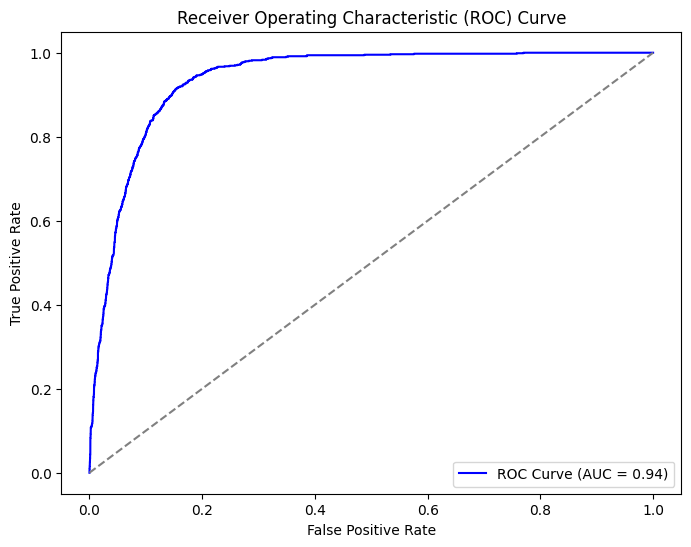

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_resampled, y_resampled)

y_pred = gb_clf.predict(X_test_scaled)
y_prob = gb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**GradientBoost-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [27128  3287]
RUS sonrası sınıf dağılımı: [3287 3287]

Confusion Matrix:
[[5668 1098]
 [  62  776]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      6766
         1.0       0.41      0.93      0.57       838

    accuracy                           0.85      7604
   macro avg       0.70      0.88      0.74      7604
weighted avg       0.93      0.85      0.87      7604


ROC AUC Score: 0.94


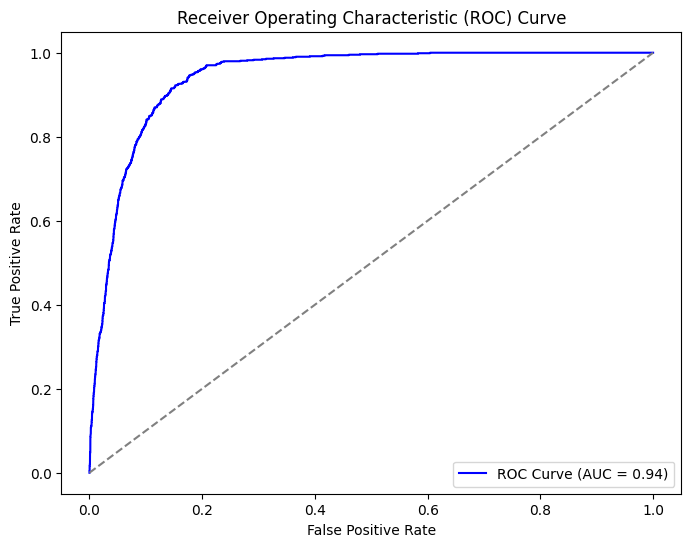

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_resampled, y_resampled)

y_pred = gb_clf.predict(X_test_scaled)
y_prob = gb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**GradientBoost-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [27128  3287]
SMOTEENN sonrası sınıf dağılımı: [22436 25684]

Confusion Matrix:
[[5861  905]
 [ 103  735]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92      6766
         1.0       0.45      0.88      0.59       838

    accuracy                           0.87      7604
   macro avg       0.72      0.87      0.76      7604
weighted avg       0.92      0.87      0.88      7604


ROC AUC Score: 0.94


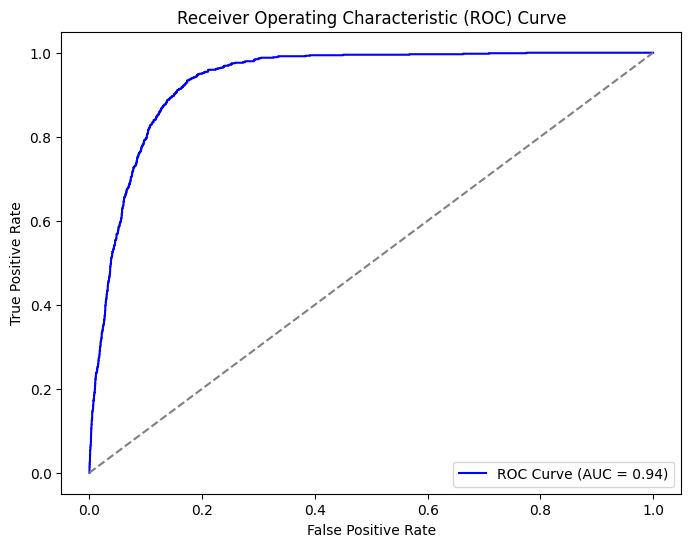

In [ ]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_resampled, y_resampled)

y_pred = gb_clf.predict(X_test_scaled)
y_prob = gb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


 **CatBoost-Weight Class**

Accuracy: 0.8807

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      6766
         1.0       0.48      0.89      0.62       838

    accuracy                           0.88      7604
   macro avg       0.73      0.89      0.78      7604
weighted avg       0.93      0.88      0.90      7604


Confusion Matrix:
[[5949  817]
 [  90  748]]


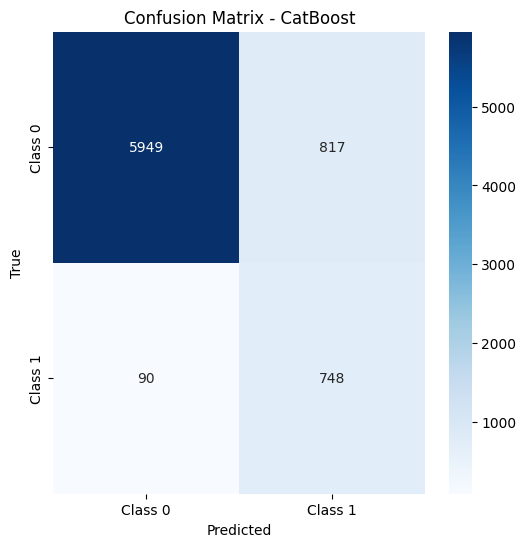

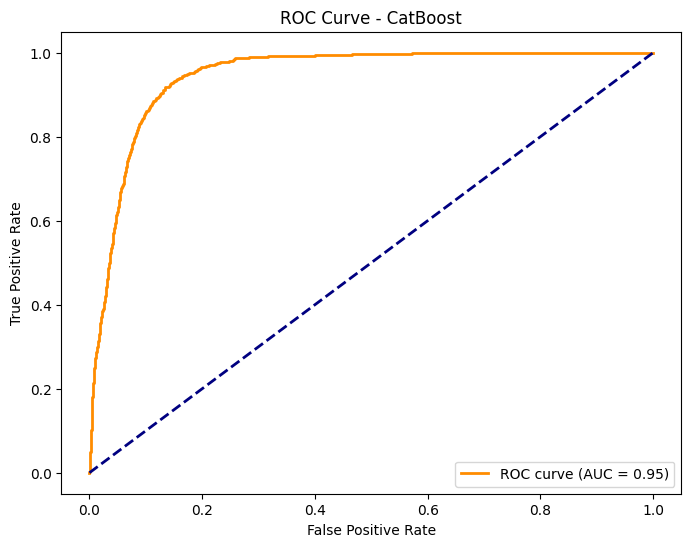

In [ ]:


catboost_model = CatBoostClassifier(iterations=1000, class_weights=[weights[0],weights[1]], random_state=42, verbose=0)

catboost_model.fit(X_train_scaled, y_train)

y_pred_catboost = catboost_model.predict(X_test_scaled)

accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print(f"Accuracy: {accuracy_catboost:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_catboost))

conf_matrix_catboost = confusion_matrix(y_test, y_pred_catboost)
print("\nConfusion Matrix:")
print(conf_matrix_catboost)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_catboost, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
y_prob_catboost = catboost_model.predict_proba(X_test_scaled)[:, 1]

fpr_catboost, tpr_catboost, _ = roc_curve(y_test, y_prob_catboost)
roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_catboost)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend(loc='lower right')
plt.show()


**CatBoost-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [27128  3287]
SMOTE sonrası sınıf dağılımı: [27128 27128]

Confusion Matrix:
[[6467  299]
 [ 366  472]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95      6766
         1.0       0.61      0.56      0.59       838

    accuracy                           0.91      7604
   macro avg       0.78      0.76      0.77      7604
weighted avg       0.91      0.91      0.91      7604


ROC AUC Score: 0.94


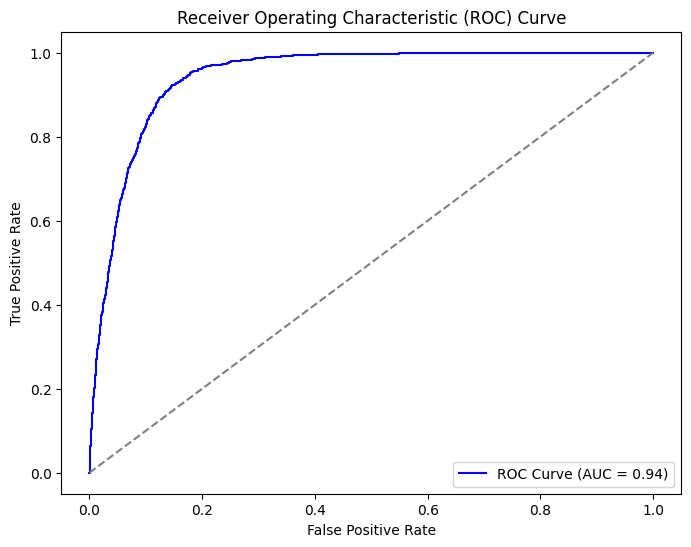

In [ ]:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")


catboost_clf = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=0)
catboost_clf.fit(X_resampled, y_resampled)

y_pred = catboost_clf.predict(X_test_scaled)
y_prob = catboost_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**CatBoost-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [27128  3287]
RUS sonrası sınıf dağılımı: [3287 3287]

Confusion Matrix:
[[5733 1033]
 [  66  772]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      6766
         1.0       0.43      0.92      0.58       838

    accuracy                           0.86      7604
   macro avg       0.71      0.88      0.75      7604
weighted avg       0.93      0.86      0.88      7604


ROC AUC Score: 0.94


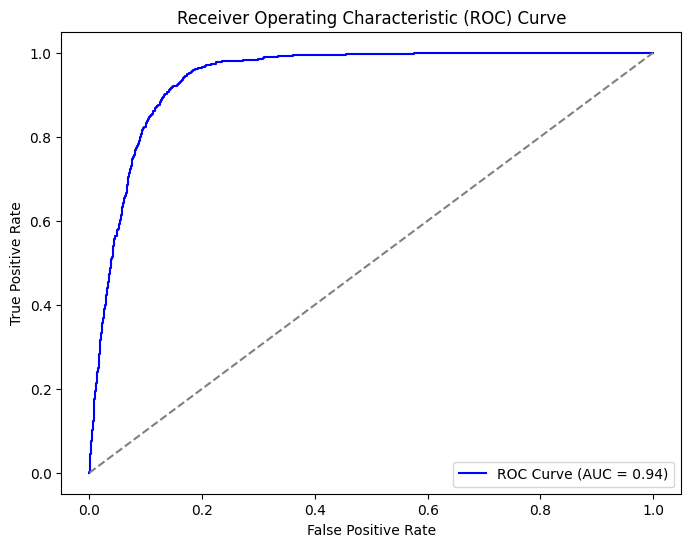

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)
catboost_clf.fit(X_resampled, y_resampled)

y_pred = catboost_clf.predict(X_test_scaled)
y_prob = catboost_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**CatBoost-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [27128  3287]
SMOTEENN sonrası sınıf dağılımı: [22436 25684]

Confusion Matrix:
[[6184  582]
 [ 195  643]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94      6766
         1.0       0.52      0.77      0.62       838

    accuracy                           0.90      7604
   macro avg       0.75      0.84      0.78      7604
weighted avg       0.92      0.90      0.91      7604


ROC AUC Score: 0.94


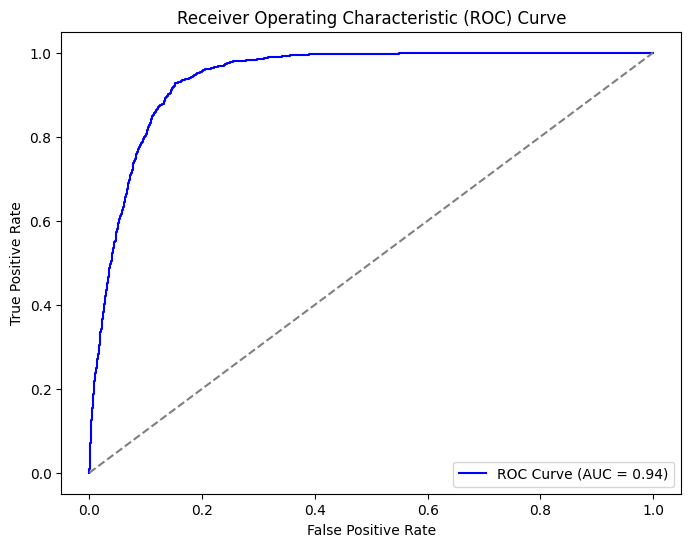

In [ ]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")


catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)
catboost_clf.fit(X_resampled, y_resampled)

y_pred = catboost_clf.predict(X_test_scaled)
y_prob = catboost_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


 **Xgboost-Weight Class**


Confusion Matrix:
[[5858  908]
 [  81  757]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92      6766
         1.0       0.45      0.90      0.60       838

    accuracy                           0.87      7604
   macro avg       0.72      0.88      0.76      7604
weighted avg       0.93      0.87      0.89      7604


ROC AUC Score: 0.94


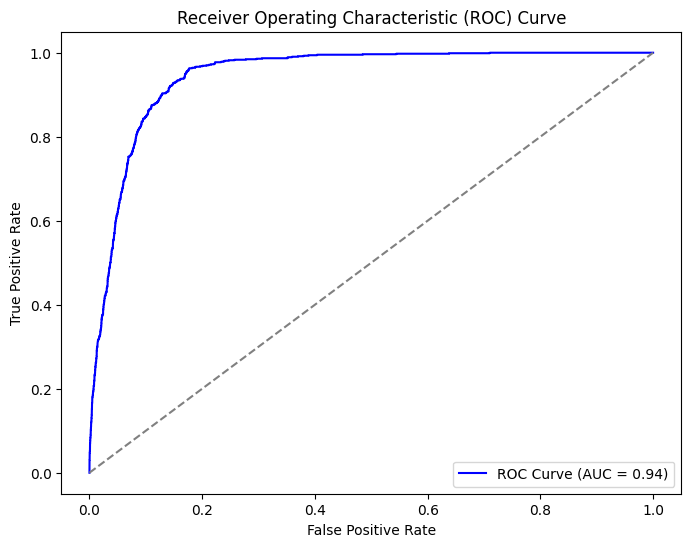

In [ ]:
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

xgb_clf = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_train_scaled, y_train)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**XgBoost-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [27128  3287]
SMOTE sonrası sınıf dağılımı: [27128 27128]

Confusion Matrix:
[[6304  462]
 [ 246  592]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      6766
         1.0       0.56      0.71      0.63       838

    accuracy                           0.91      7604
   macro avg       0.76      0.82      0.79      7604
weighted avg       0.92      0.91      0.91      7604


ROC AUC Score: 0.94


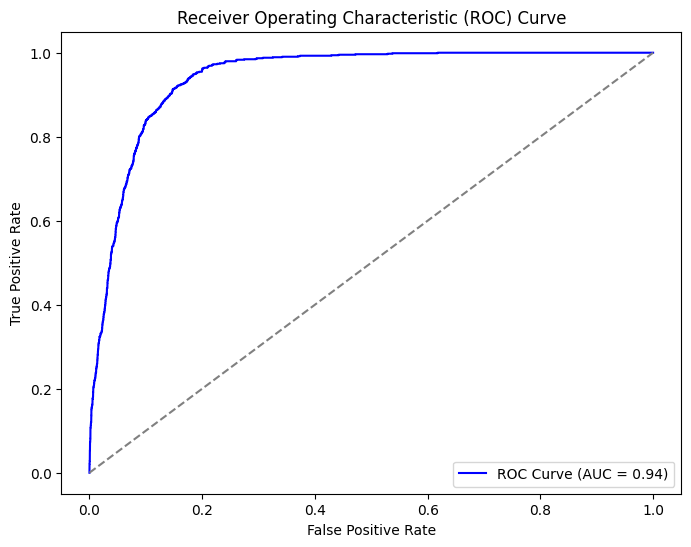

In [ ]:



smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")


xgb_clf = xgb.XGBClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**XgBoost-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [27128  3287]
RUS sonrası sınıf dağılımı: [3287 3287]

Confusion Matrix:
[[5729 1037]
 [  62  776]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      6766
         1.0       0.43      0.93      0.59       838

    accuracy                           0.86      7604
   macro avg       0.71      0.89      0.75      7604
weighted avg       0.93      0.86      0.88      7604


ROC AUC Score: 0.94


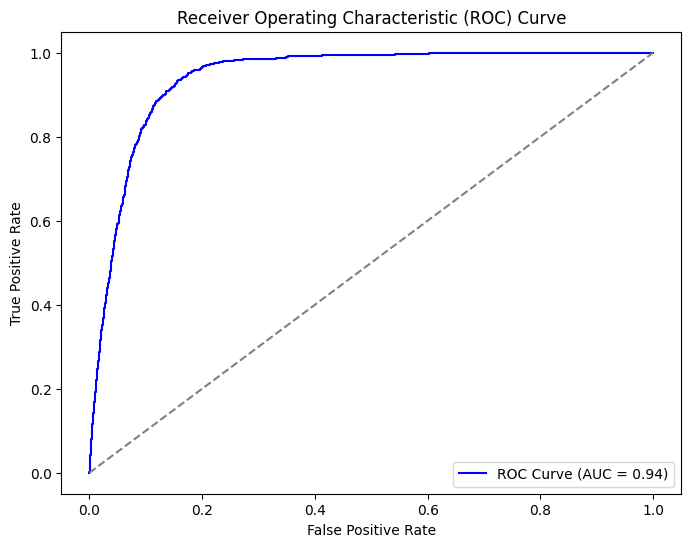

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
   random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**XgBoost-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [27128  3287]
SMOTEENN sonrası sınıf dağılımı: [22436 25684]

Confusion Matrix:
[[6066  700]
 [ 155  683]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.93      6766
         1.0       0.49      0.82      0.62       838

    accuracy                           0.89      7604
   macro avg       0.73      0.86      0.77      7604
weighted avg       0.92      0.89      0.90      7604


ROC AUC Score: 0.94


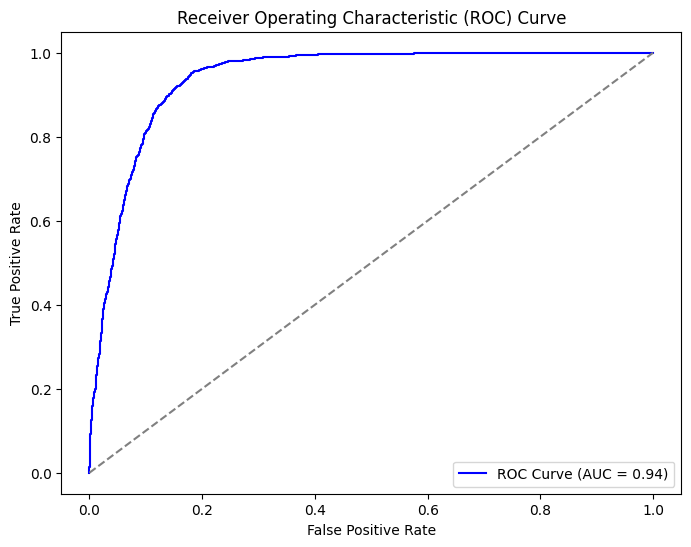

In [ ]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
  random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


 **RandomForest-Weight Class**


Confusion Matrix:
[[6561  205]
 [ 475  363]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      6766
         1.0       0.64      0.43      0.52       838

    accuracy                           0.91      7604
   macro avg       0.79      0.70      0.73      7604
weighted avg       0.90      0.91      0.90      7604


ROC AUC Score: 0.94


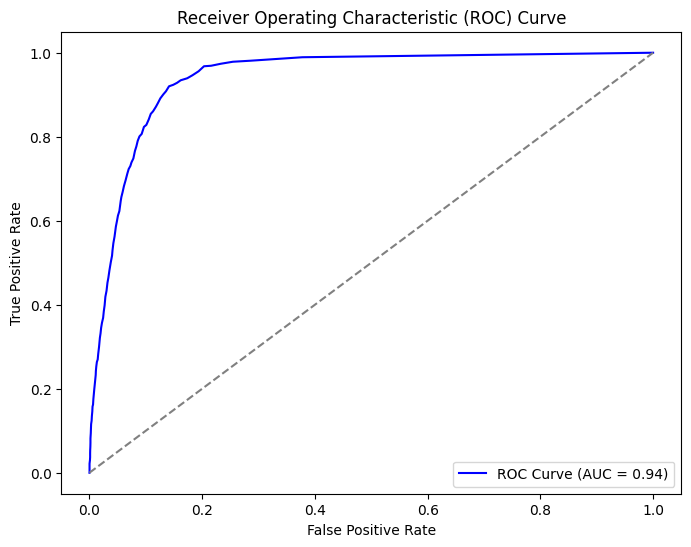

In [ ]:


random_forest_clf = RandomForestClassifier(
    class_weight={0: weights[0],1: weights[1] },
    n_estimators=100,
    random_state=42
)

random_forest_clf.fit(X_train_scaled, y_train)

y_pred = random_forest_clf.predict(X_test_scaled)
y_prob = random_forest_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [27128  3287]
SMOTE sonrası sınıf dağılımı: [27128 27128]

Confusion Matrix:
[[6343  423]
 [ 283  555]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      6766
         1.0       0.57      0.66      0.61       838

    accuracy                           0.91      7604
   macro avg       0.76      0.80      0.78      7604
weighted avg       0.91      0.91      0.91      7604


ROC AUC Score: 0.94


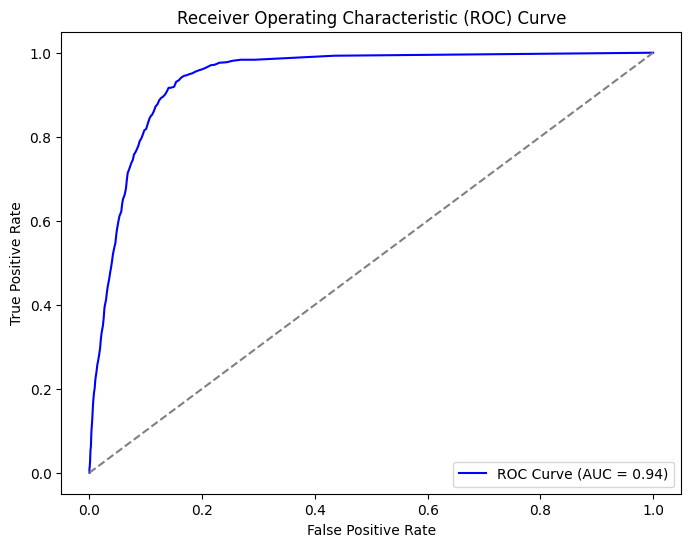

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

random_forest_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

random_forest_clf.fit(X_resampled, y_resampled)


y_pred = random_forest_clf.predict(X_test_scaled)
y_prob = random_forest_clf.predict_proba(X_test_scaled)[:, 1]
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [27128  3287]
RUS sonrası sınıf dağılımı: [3287 3287]

Confusion Matrix:
[[5716 1050]
 [  65  773]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      6766
         1.0       0.42      0.92      0.58       838

    accuracy                           0.85      7604
   macro avg       0.71      0.88      0.75      7604
weighted avg       0.93      0.85      0.87      7604


ROC AUC Score: 0.94


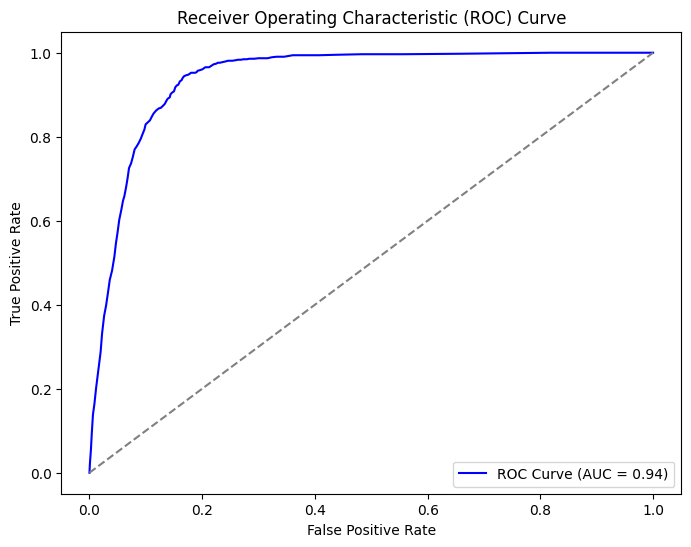

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_clf.fit(X_resampled, y_resampled)

y_pred = rf_clf.predict(X_test_scaled)
y_prob = rf_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [27128  3287]
SMOTEENN sonrası sınıf dağılımı: [22436 25684]

Confusion Matrix:
[[6083  683]
 [ 158  680]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.94      6766
         1.0       0.50      0.81      0.62       838

    accuracy                           0.89      7604
   macro avg       0.74      0.86      0.78      7604
weighted avg       0.92      0.89      0.90      7604


ROC AUC Score: 0.94


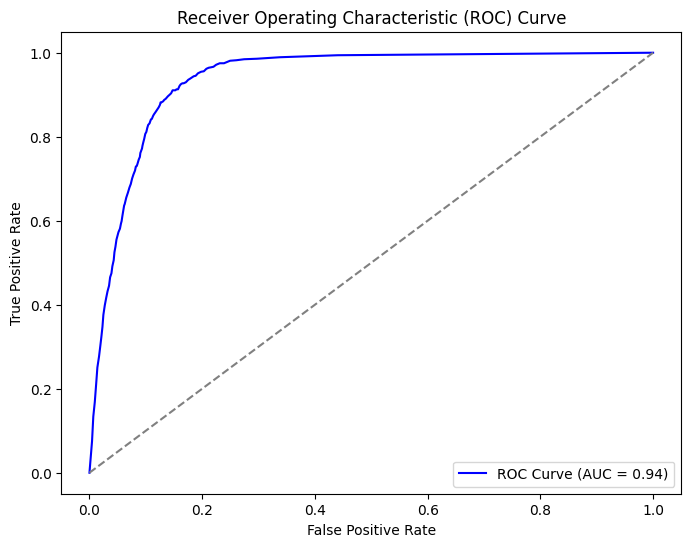

In [ ]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_clf.fit(X_resampled, y_resampled)

y_pred = rf_clf.predict(X_test_scaled)
y_prob = rf_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# **Best Model Feature Selection**

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
   random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

best_model=xgb_clf.fit(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [27128  3287]
RUS sonrası sınıf dağılımı: [3287 3287]


In [ ]:
feature_importance=best_model.feature_importances_
gbt_fi_df=pd.DataFrame({"Feature" : X.columns, "Importance": feature_importance})
gbt_fi_df=gbt_fi_df.sort_values(by="Importance",ascending=False)
gbt_fi_df

,Feature,Importance
10,duration,0.221844
16,cons.conf.idx,0.164111
17,euribor3m*emp.var.rate*nr.employed,0.137513
12,pdays,0.115733
4,default,0.055173
14,poutcome,0.036411
3,education,0.028599
9,day_of_week,0.027998
7,contact,0.025111
15,cons.price.idx,0.024957


In [ ]:
Selected_Features=list(gbt_fi_df[gbt_fi_df["Importance"]>0.03].Feature)

In [ ]:
Selected_Features.append("y")

In [ ]:
df_new=df_cleaned[Selected_Features]
df_new.head()

,duration,cons.conf.idx,euribor3m*emp.var.rate*nr.employed,pdays,default,poutcome,y
0,261.0,-36.4,27733.9557,0.0,1.0,1.0,0.0
1,149.0,-36.4,27733.9557,0.0,0.0,1.0,0.0
2,226.0,-36.4,27733.9557,0.0,1.0,1.0,0.0
3,151.0,-36.4,27733.9557,0.0,1.0,1.0,0.0
4,307.0,-36.4,27733.9557,0.0,1.0,1.0,0.0


In [ ]:
X=df_new.drop("y",axis=1)
y=df_new["y"]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [ ]:
scaler=MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [27128  3287]
RUS sonrası sınıf dağılımı: [3287 3287]

Confusion Matrix:
[[5635 1131]
 [  52  786]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.91      6766
         1.0       0.41      0.94      0.57       838

    accuracy                           0.84      7604
   macro avg       0.70      0.89      0.74      7604
weighted avg       0.93      0.84      0.87      7604


ROC AUC Score: 0.94


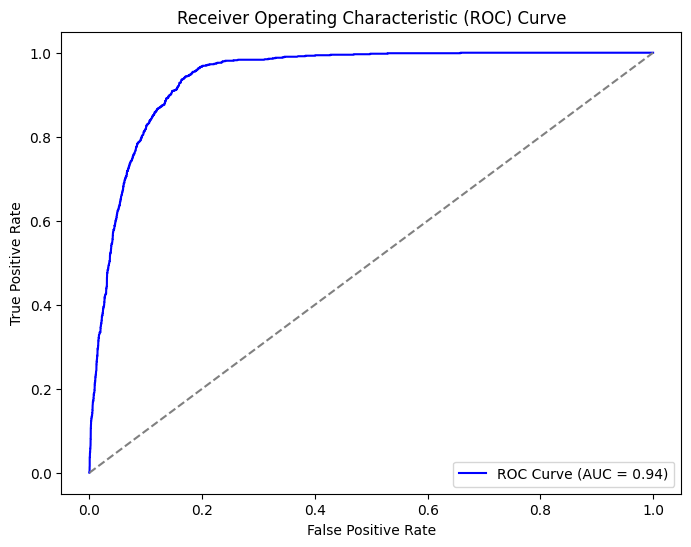

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
   random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
